# Genome Assembly Tutorial

The OLC graph was constructed on scratch paper using some of the data I generated here as a guidance tool. For the de Bruijn graph method, I used the networkx package to create a multi-layered directed graph of the kmers and then search it for a eulerian path representing the genome assembly. This resulted in a failure to find a eulerian path after searching all possible starting nodes. The "down and dirty" visualizations I created of the graphs illustrate some of the complications which may have led to this error--such as disconnected subgraphs and circular edges connecting a node to itself.

Documentation on the networkx package and methods that I used can be found here: https://networkx.org/documentation/stable/index.html

My general approach to the de Bruijn graph genome assembly task follows the methodology outlined by Compeau and colleagues:
- Compeau PE, Pevzner PA, Tesler G. How to apply de Bruijn graphs to genome assembly. Nat Biotechnol. 2011 Nov 8;29(11):987-91. doi: 10.1038/nbt.2023. PMID: 22068540; PMCID: PMC5531759.

In [1]:
# import graph and plotting utilities
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
#data from assignment
tiny_dino_reads = ['TTCGGA', 'GACTTC', 'AGACTT', 'TTCACG', 'AGCTAT', 'GAAAGC', 'CTATTC']

### OLC graph of the reads with overlap score of 2 or higher

In [3]:
# importing sequencematcher object to simplify overlaps
import difflib

def get_overlap(s1, s2):
    s = difflib.SequenceMatcher(None, s1, s2)
    pos_a, pos_b, size = s.find_longest_match(0, len(s1), 0, len(s2)) 
    return s1[pos_a:pos_a+size]

In [4]:
#generate longest overlap for each possible pairing
def poss_edges(read_list):
    v_poss_edges = []
    for i,v in enumerate(read_list):
        temp = [v for v in read_list] # list comp needed to avoid referencing issues
        temp.pop(i)
        p_edges = [(get_overlap(v,x), x) for x in temp if len(get_overlap(v,x))>=2] #keep only overlaps 2 or greater
        v_poss_edges.append((v, p_edges))
    df = pd.DataFrame(data=v_poss_edges, columns=["vertex", "possible_edges"])
    return df

In [5]:
table = poss_edges(tiny_dino_reads)
table

,vertex,possible_edges
0,TTCGGA,"[(TTC, GACTTC), (TT, AGACTT), (TTC, TTCACG), (..."
1,GACTTC,"[(TTC, TTCGGA), (GACTT, AGACTT), (TTC, TTCACG)..."
2,AGACTT,"[(GA, TTCGGA), (GACTT, GACTTC), (AC, TTCACG), ..."
3,TTCACG,"[(TTC, TTCGGA), (TTC, GACTTC), (TT, AGACTT), (..."
4,AGCTAT,"[(CT, GACTTC), (AG, AGACTT), (AGC, GAAAGC), (C..."
5,GAAAGC,"[(GA, TTCGGA), (GA, GACTTC), (GA, AGACTT), (AG..."
6,CTATTC,"[(TTC, TTCGGA), (TTC, GACTTC), (CT, AGACTT), (..."


In [6]:
#filter edges that do not overlap with correct orientation
for n,i in enumerate(table["possible_edges"]):
    for j in i:
        if j[1].startswith(j[0]):
            continue
        if table["vertex"][n].endswith(j[0]):
            continue
        else:
            i.remove(j)

table

,vertex,possible_edges
0,TTCGGA,"[(TT, AGACTT), (TTC, TTCACG), (GA, GAAAGC)]"
1,GACTTC,"[(TTC, TTCGGA), (TTC, TTCACG), (GA, GAAAGC), (..."
2,AGACTT,"[(GACTT, GACTTC), (AG, AGCTAT), (CT, CTATTC)]"
3,TTCACG,"[(TTC, TTCGGA), (TT, AGACTT)]"
4,AGCTAT,"[(AG, AGACTT), (CTAT, CTATTC)]"
5,GAAAGC,"[(GA, GACTTC), (AGC, AGCTAT)]"
6,CTATTC,"[(TTC, TTCGGA), (TTC, GACTTC), (TTC, TTCACG)]"


### DBG graph of k=3

In [7]:
#kmer objects for storing info
class kmer:
    def __init__(self, sequence):
        self.sequence = sequence
        self.prefix = sequence[:-1]
        self.suffix = sequence[1:]

In [8]:
#find kmers given k
def kmers(sequence, k):
    kmers = []
    for i,base in enumerate(sequence):
        window = (i+k)
        if len(sequence[i:])>=k:
            kmers.append(kmer(sequence[i:window]))
        else:
            break
    return kmers

#sanity check
for i in kmers('atggaa', 3):
    print(i.sequence, i.prefix, i.suffix)

atg at tg
tgg tg gg
gga gg ga
gaa ga aa


{'AT', 'CA', 'GG', 'TA', 'CG', 'AA', 'TC', 'AC', 'AG', 'CT', 'TT', 'GA', 'GC'}
[('AT', 'TT', {'kmr': 'ATT'}), ('CA', 'AC', {'kmr': 'CAC'}), ('GG', 'GA', {'kmr': 'GGA'}), ('TA', 'AT', {'kmr': 'TAT'}), ('TA', 'AT', {'kmr': 'TAT'}), ('CG', 'GG', {'kmr': 'CGG'}), ('AA', 'AA', {'kmr': 'AAA'}), ('AA', 'AG', {'kmr': 'AAG'}), ('TC', 'CG', {'kmr': 'TCG'}), ('TC', 'CA', {'kmr': 'TCA'}), ('AC', 'CT', {'kmr': 'ACT'}), ('AC', 'CT', {'kmr': 'ACT'}), ('AC', 'CG', {'kmr': 'ACG'}), ('AG', 'GA', {'kmr': 'AGA'}), ('AG', 'GC', {'kmr': 'AGC'}), ('AG', 'GC', {'kmr': 'AGC'}), ('CT', 'TT', {'kmr': 'CTT'}), ('CT', 'TT', {'kmr': 'CTT'}), ('CT', 'TA', {'kmr': 'CTA'}), ('CT', 'TA', {'kmr': 'CTA'}), ('TT', 'TC', {'kmr': 'TTC'}), ('TT', 'TC', {'kmr': 'TTC'}), ('TT', 'TC', {'kmr': 'TTC'}), ('TT', 'TC', {'kmr': 'TTC'}), ('GA', 'AC', {'kmr': 'GAC'}), ('GA', 'AC', {'kmr': 'GAC'}), ('GA', 'AA', {'kmr': 'GAA'}), ('GC', 'CT', {'kmr': 'GCT'})]


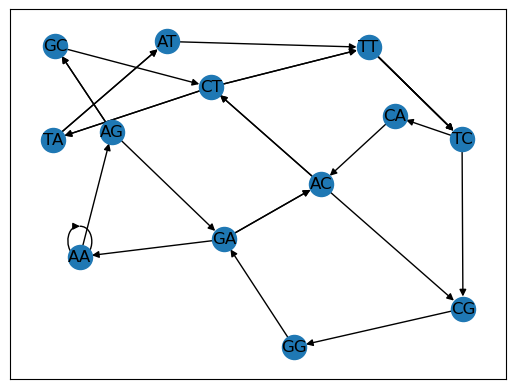

In [13]:
# instantiate multi-layer directed graph
G3 = nx.MultiDiGraph()

#generate kmers
kmers_3 = []
for s in tiny_dino_reads:
    for m in kmers(sequence=s,k=3):
        kmers_3.append(m)

#add unique (k-1)mer nodes per eulerian construction
nodes = set([i.prefix for i in kmers_3]+[i.suffix for i in kmers_3])
print(nodes)
G3.add_nodes_from(nodes)

#add edge for each kmer with prefix/suffix matching
for e in kmers_3:
    G3.add_edge(e.prefix, e.suffix, kmr=e.sequence)
print(G3.edges(data=True))

#scratch visualization
nx.draw_networkx(G3)

In [14]:
# try to find eulerian path
kmer_3_path = [x for x in nx.eulerian_path(G3, keys=True)]
kmer_3_path

NetworkXError: Graph has no Eulerian paths.

In [15]:
# check circular
kmer_3_circuit = [u for u, v in nx.eulerian_circuit(G3)]
kmer_3_circuit

NetworkXError: G is not Eulerian.

In [16]:
print(f"edges: {len(G3.edges)}")
print(f"in edges: {len(G3.in_edges)}")
print(f"out edges: {len(G3.out_edges)}")
print(f"nodes: {len(G3.nodes)}")

edges: 28
in edges: 28
out edges: 28
nodes: 13


### DBG graph of k=5

{'CGGA', 'TTCG', 'CTTC', 'AAGC', 'TATT', 'CACG', 'TTCA', 'TCAC', 'AAAG', 'ACTT', 'GCTA', 'GACT', 'AGCT', 'CTAT', 'TCGG', 'AGAC', 'GAAA', 'ATTC'}
[('TTCG', 'TCGG', {'kmr': 'TTCGG'}), ('TATT', 'ATTC', {'kmr': 'TATTC'}), ('TTCA', 'TCAC', {'kmr': 'TTCAC'}), ('TCAC', 'CACG', {'kmr': 'TCACG'}), ('AAAG', 'AAGC', {'kmr': 'AAAGC'}), ('ACTT', 'CTTC', {'kmr': 'ACTTC'}), ('GCTA', 'CTAT', {'kmr': 'GCTAT'}), ('GACT', 'ACTT', {'kmr': 'GACTT'}), ('GACT', 'ACTT', {'kmr': 'GACTT'}), ('AGCT', 'GCTA', {'kmr': 'AGCTA'}), ('CTAT', 'TATT', {'kmr': 'CTATT'}), ('TCGG', 'CGGA', {'kmr': 'TCGGA'}), ('AGAC', 'GACT', {'kmr': 'AGACT'}), ('GAAA', 'AAAG', {'kmr': 'GAAAG'})]


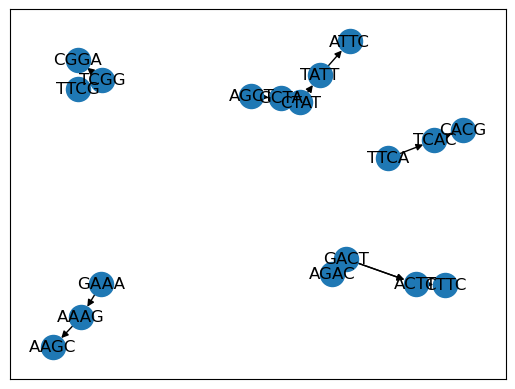

In [17]:
# instantiate multi-layer directed graph
G5 = nx.MultiDiGraph()

#generate kmers
kmers_5 = []
for s in tiny_dino_reads:
    for m in kmers(sequence=s,k=5):
        kmers_5.append(m)

#add unique (k-1)mer nodes per eulerian construction
nodes = set([i.prefix for i in kmers_5]+[i.suffix for i in kmers_5])
print(nodes)
G5.add_nodes_from(nodes)

#add edge for each kmer with prefix/suffix matching
for e in kmers_5:
    G5.add_edge(e.prefix, e.suffix, kmr=e.sequence)
print(G5.edges(data=True))

#scratch visualization
nx.draw_networkx(G5)

In [18]:
# try to find eulerian path
kmer_5_path = [x for x in nx.eulerian_path(G5, keys=True)]
kmer_5_path

NetworkXError: Graph has no Eulerian paths.

### Part 3: Q and A

Did you get the same answer from all approaches? If not describe why.
- As noted above, I was unable to obtain an answer using the de Bruijn graph method, although I was able to obtain one with the OLC method by hand. This is likely due to the complexity of the graphs I constructed and the artifact found in each graph due to the small size of the genome and reads used in this example. It would be interesting to investigate the cause of this issue in more depth.

What approach do you think was the most accurate?
- Due to the small scale of this exercise, I think the overlap consensus method was the most accurate. However, this is also an empty truism considering neither of the other 2 graphs satisfied the eulerian condition necessary to assemble the genome. It is also worth noting that the de Bruijn graph method is significantly more scalable than the OLC method, which is critical when dealing with real genomes that may be enormous compared to this exercise.